# **TCC_p01_preparar_X_treinamento_e_y_teste.ipynb**

# **Etapa 1 - Gerar arquivos de treinamento e de teste**
O objetivo deste notebook é preparar e salvar os dataframes **X e y**. O **X** será usado para treinar os diferentes modelos (SpaCy e DCNN com stemer, lema e palavras originais) e o **y** será utilizado para apuração da acurácia dos modelos de classificação. Posteriormente, o mesmo **y** será utilizado por todos os sumarizadores para a geração dos resumos e, em seguida, para apuração da acurácia do modelo escolhido em relação aos resumos. Como a base para as experiências precisa ser a mesma, após a preparação dos dados e a divisão em **X e y**, os dataframes serão salvos no drive. Assim, esse procedimento será executado apenas uma vez.

1.   Importação de bibliotecas
> As bibliotecas utilizadas foram ***Pandas***, para criação e manipulação de dataframes, ***re***, para utilização das expressões regulares em operações de pesquisas em string.
Utilizei o ***train_test_split***, função da ***scikit-learn***, para dividir a base. O *train_test_split* permite a indicação de um inteiro para saída reproduzível em várias chamadas de função e a definição do percentual para divisão da amostra. Escolhi 80% para a base de treinamento e 20% para a base de teste.

2.   Montar Drive
> Com ***drive.mount***('/content/drive', force_remount=True) os diretórios de dados do ***Google Drive*** são montados para utilização no ***Colab*** permitindo salvar arquivos e modelos treinados para utilização posterior, inclusive, em outros notebooks.

3.   Ler os dataframes df_atributos e df_voto gerados pelo script TCC Big Data - Ler pdf acordao e salvos no Drive
> Conforme descrito no item do texto principal do TCC **2. Coleta de Dados**, foram criados 
2 dataframes contendo os atributos e os votos dos acórdãos Carf. Os arquivos foram salvos no drive. Neste notebook, são lidos a partir do drive e são a base para a criação dos dataframes **X e y**.

4.   Concatenar as frases gerando o voto completo
> O voto será utilizado como atributo para a classificação dos dados. O voto no df_voto foi carregado em até 510 colunas chamadas *frase001* a *frase510*. Essas frases devem ser concatenadas formando uma coluna única. Para isso, criei a função ***concatena_frases***. A função está descrita em docstring reproduzido a seguir.
> * Concatena as frases do voto agrupando-as em uma única string. Despreza as frases com menos de 4 palavras e os conteúdos NaN. Despreza a primeira coluna que contém o número do processo.
> * parâmetro linha: recebe as linhas do df que contêm as frases do voto.
> * retorno texto_original: string contendo o voto completo após a concatenação das frases.

5.   Contar o número de frases
> O objetivo de calcular o número de sentenças foi selecionar apenas os textos com pelo menos 10 sentenças, pois a sumarização de textos pequenos não é muito útil e poderia prejudicar a análise da qualidade dos sumarizadores. A função está descrita em docstring reproduzido a seguir.
> * Calcula a quantidade de frases/sentenças do voto. Não considera as frases com menos de 4    palavras e os conteúdos NaN. 
> * parâmetro linha: recebe as linhas do df que contêm as frases do voto.
> * retorno qtd: int contendo a quantidade de frases da linha.

6.   Selecionar os assuntos/categorias 'irpf', 'ngdt', 'irpj' e 'paf' e desprezar os votos com menos de 10 frases
> * Selecionei os 4 assuntos com maior quantidade de processos. São eles o Imposto de Renda da Pessoa Jurídica (IRPJ), o Imposto de Renda da Pessoa Física (IRPF), as Normas gerais de direito tributário (NGDT) e o Processo administrativo fiscal (PAF). 
> * Foram selecionados: IRPF 3734; NGDT 2479; IRPJ 2331 e PAF 1927.
> * Foram selecionados apenas os processos cujo voto tinha 10 frases ou mais.
> * Após o corte pelo número de frases, os selecionados foram IRPF 2994; NGDT 2155; IRPJ 2145 e PAF 1611.

7.   Criar X_treinamento, X_teste, y_treinamento e y_teste na proporção 80%/20% e gravá-los no Drive, sendo X = voto e y = assunto
> Utilizei o encoding Windows-1252, uma codificação de caracteres de byte único do alfabeto latino, usada por padrão nos componentes herdados do Microsoft Windows que se mostrou adequada aos textos utilizados. Os arquivos gravados no drive foram os seguintes:
> * X_treinamento_7124.csv
> * y_treinamento_7124.csv
> * X_teste_1781.csv
> * y_teste_1781.csv







In [ ]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/df_atributos.csv' 
df_a = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True)
df_a.columns = df_a.columns.str.lower() 
url = '/content/drive/MyDrive/df_voto.csv' 
df_v = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False) 
df_v.columns = df_v.columns.str.lower() 
print(f'{df_a.shape}, {df_v.shape}')

(18594, 9), (18594, 511)


In [ ]:
df_a.assunto.describe()

count     18586
unique       30
top        irpf
freq       3734
Name: assunto, dtype: object

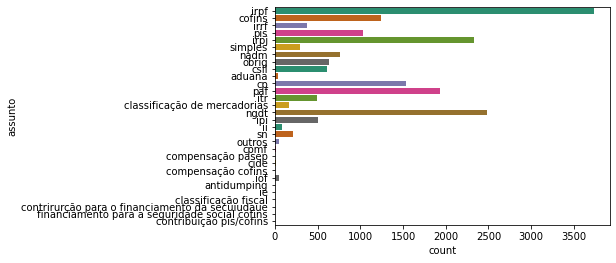

In [ ]:
sns.countplot(y="assunto", palette="Dark2", data=df_a);

In [ ]:
df_a.assunto.value_counts()

irpf                                               3734
ngdt                                               2479
irpj                                               2331
paf                                                1927
cp                                                 1535
cofins                                             1237
pis                                                1029
nadm                                                765
obrig                                               635
csll                                                609
ipi                                                 500
itr                                                 491
irrf                                                380
simples                                             292
sn                                                  214
classificação de mercadorias                        159
ii                                                   88
outros                                          

In [ ]:
pd_options = pd.options.display # Objeto para configuração do ambiente: número de linhas, colunas, precisão e etc
pd_options.max_colwidth = 15

In [ ]:
df_v.head(10)[1:3]

,processo,frase001,frase002,frase003,frase004,frase005,frase006,frase007,frase008,frase009,frase010,frase011,frase012,frase013,frase014,frase015,frase016,frase017,frase018,frase019,frase020,frase021,frase022,frase023,frase024,frase025,frase026,frase027,frase028,frase029,frase030,frase031,frase032,frase033,frase034,frase035,frase036,frase037,frase038,frase039,...,frase471,frase472,frase473,frase474,frase475,frase476,frase477,frase478,frase479,frase480,frase481,frase482,frase483,frase484,frase485,frase486,frase487,frase488,frase489,frase490,frase491,frase492,frase493,frase494,frase495,frase496,frase497,frase498,frase499,frase500,frase501,frase502,frase503,frase504,frase505,frase506,frase507,frase508,frase509,frase510
1,10070000654...,o recurso v...,no que conc...,cabe mencio...,"a folha 10,...","238,50 e ...",não const...,assim o lan...,do exame do...,quanto à co...,o sujeito p...,cumpre escl...,por todo o ...,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10070000947...,por ser tem...,conforme já...,parágrafo ú...,poderá ser ...,juntamente ...,muito embor...,nos termos ...,por outro l...,tal conclus...,não obstant...,por outro l...,"contudo, o ...",carlos albe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def concatena_frases(linha):
  """
  Concatena as frases do voto agrupando-as em uma única string. Despreza as frases com menos de 4 palavras e 
  os conteúdos NaN. Despreza a primeira coluna que contém o número do processo.

  :parâmetro linha: recebe as linhas do df que contêm as frases do voto.
  :retorno texto_original: string contendo o voto completo após a concatenação das frases.
  """
  texto_original = ''
  primeira_coluna = True
  for conteudo_coluna in linha:
    if primeira_coluna == True:
      primeira_coluna = False
      continue
    if isinstance(conteudo_coluna, str):
      if re.search('[a-zA-Z0-9]+ [a-zA-Z0-9]+ [a-zA-Z0-9]+ [a-zA-Z0-9]+', str(conteudo_coluna)):
        texto_original += conteudo_coluna + ' '
  return texto_original

In [ ]:
def soma_frases(linha):
  """
  Calcula a quantidade de frases/sentenças do voto. Não considera as frases com menos de 4 palavras e 
  os conteúdos NaN. 
  
  :parâmetro linha: recebe as linhas do df que contêm as frases do voto.
  :retorno qtd: int contendo a quantidade de frases da linha.
  """
  qtd = 0
  primeira_coluna = True
  for conteudo_coluna in linha: 
    if primeira_coluna == True:
      primeira_coluna = False
      continue
    if isinstance(conteudo_coluna, str):
      if re.search('[a-zA-Z0-9]+ [a-zA-Z0-9]+ [a-zA-Z0-9]+ [a-zA-Z0-9]+', str(conteudo_coluna)): #despreza linhas que não tenham pelo menos 4 palavras.
        qtd += 1
  return qtd

In [ ]:
def intervalo_frases(linha):
  if linha.loc['qtdfrase'] < 10:
    return '001-009'
  elif linha.loc['qtdfrase'] < 51:
    return '010-050'
  elif linha.loc['qtdfrase'] < 101:
    return '051-100'
  elif linha.loc['qtdfrase'] < 151:
    return '100-150'
  else:
    return '150-321'

In [ ]:
#obtém lista com o título de todas as colunas frase para exclusão das colunas
lista_colunas = list(df_v.columns)
lista_colunas.pop(0) #processo

'processo'

In [ ]:
pd_options = pd.options.display # Objeto para configuração do ambiente: número de linhas, colunas, precisão e etc
pd_options.max_colwidth = 200

In [ ]:
#inclui a coluna quantidade de frases. Considera apenas as frase com pelo menos 4 palavras.
df_v['qtdfrase'] = df_v.apply(soma_frases, axis=1)
#inclui a coluna voto com o conteúdo de todas as frases. Considera apenas as frase com pelo menos 4 palavras.
df_v['voto'] = df_v.apply(concatena_frases, axis=1)
#exclui as colunas frase
df_v.drop(columns=lista_colunas, inplace=True)
#inclui coluna com intervalo de quantidade de frases
df_v['intervalofrase'] = df_v.apply(intervalo_frases, axis=1)
df_v.head()

,processo,qtdfrase,voto,intervalofrase
0,10070000461200797,2,o cerne da discordância nos presentes autos como bem identificado na resolução de folhas 114/116 e não considerado pela drj em decorrência de falta de provas pela contribuinte foi: em julgamen...,001-009
1,10070000654200748,11,"o recurso voluntário é tempestivo e reúne os requisitos de admissibilidade, portanto, dele tomo conhecimento. no que concerne à omissão de rendimentos, verifica-se que a recorrente concorda com ...",010-050
2,10070000947200644,12,"por ser tempestivo e por preencher as demais condições de admissibilidade, conheço do presente recurso voluntário. conforme já descrito no relatório supra, o pleito recursal se restringe ao apro...",010-050
3,10070001028200264,16,"- da prescrição intercorrente na merece guarida a pretensão recursal em tal tópico. o tema está pacificado na jurisprudência administrativa, conforme precedentes a seguir transcritos: assunto...",010-050
4,10070001083200254,16,"o recurso voluntário é tempestivo e preenche os requisitos de admissibilidade, por isto dele conheço. conforme relatado, o crédito pleiteado pela contribuinte não foi reconhecido, pois conforme ...",010-050


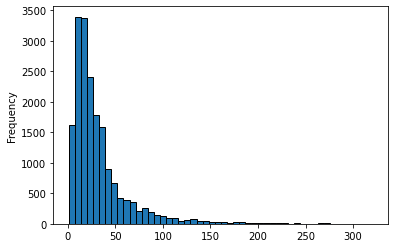

In [ ]:
df_v["qtdfrase"].plot.hist(bins=50, edgecolor='black')

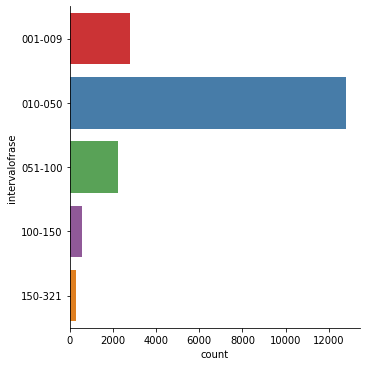

In [ ]:
sns.catplot(y="intervalofrase", kind="count", palette="Set1", data=df_v);

In [ ]:
df_v.intervalofrase.value_counts()

010-050    12788
001-009     2776
051-100     2219
100-150      546
150-321      265
Name: intervalofrase, dtype: int64

In [ ]:
df_v.qtdfrase.mean()

32.368075723351616

In [ ]:
df_a.head(3)[1:3]

,processo,recurso,materia,assunto,relator,presidente,conselheiros,decisao,voto vencedor
1,10070000654200748,voluntário,irpf - omissão de rendimentos,irpf,mônica renata mello fereira stoll,cláudia cristina noira passos da costa develly montez,"claudia cristina noira passos da costa develly montez, mônica renata mello fereira stoll, thiago duca amoni e virgílio cansino gil.",unanimidade,NaN
2,10070000947200644,voluntário,irpf,irpf,determinando o recalculo do tributo devido nos termos do voto do,carlos henrique de oliveira,"carlos henrique de oliveira, ana cecília lustosa da cruz, dione jesabel wasilewski, josé alfredo duarte filho, marcelo milton da silva risso, carlos alberto do amaral azeredo, daniel melo mendes...",unanimidade,NaN


In [ ]:
#cria o dataframe df com as colunas do df_voto incluindo a coluna alvo 'assunto' obtida no df_atributos.
dict_df = {'processo':list(df_v['processo']), 'voto':list(df_v['voto']), 'qtdfrase':list(df_v['qtdfrase']), 'intervalofrase':list(df_v['intervalofrase']), 'assunto':list(df_a['assunto'])}
df = pd.DataFrame(dict_df)

In [ ]:
#seleciona apenas os quatro assuntos (irpf, ngdt, irpj e paf) com maior quantidade de processos. 
df = df[(df['assunto'] == 'irpf') | (df['assunto'] == 'ngdt') | 
        (df['assunto'] == 'irpj') | (df['assunto'] == 'paf')] 

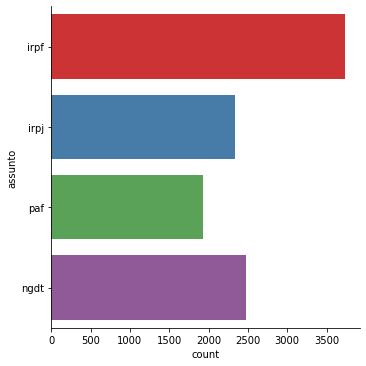

In [ ]:
sns.catplot(y="assunto", kind="count", palette="Set1", data=df);

In [ ]:
df.assunto.value_counts()

irpf    3734
ngdt    2479
irpj    2331
paf     1927
Name: assunto, dtype: int64

In [ ]:
#exclui processos com menos de 10 frases
df = df[df['qtdfrase'] > 9]

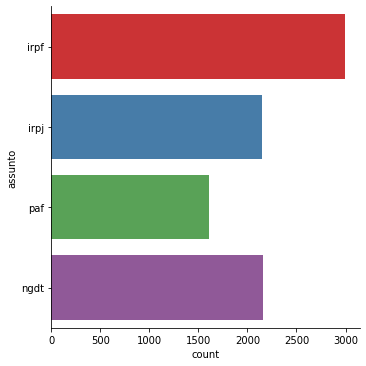

In [ ]:
sns.catplot(y="assunto", kind="count", palette="Set1", data=df);

In [ ]:
df.assunto.value_counts()

irpf    2994
ngdt    2155
irpj    2145
paf     1611
Name: assunto, dtype: int64

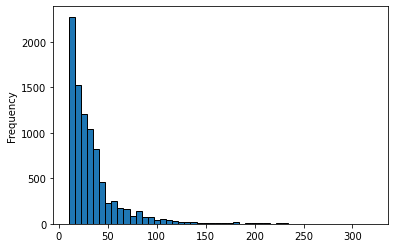

In [ ]:
df["qtdfrase"].plot.hist(bins=50, edgecolor='black')

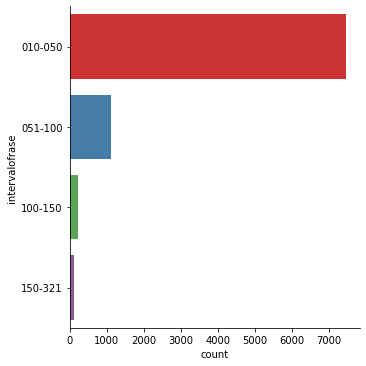

In [ ]:
sns.catplot(y="intervalofrase", kind="count", palette="Set1", data=df);

In [ ]:
df.intervalofrase.value_counts()

010-050    7456
051-100    1104
100-150     229
150-321     116
Name: intervalofrase, dtype: int64

In [ ]:
df.qtdfrase.mean()

34.346996069623806

In [ ]:
df.shape

(8905, 4)

In [ ]:
df.head()

,processo,voto,qtdfrase,assunto
1,10070000654200748,o recurso voluntário é tempestivo e reúne os r...,11,irpf
2,10070000947200644,por ser tempestivo e por preencher as demais c...,12,irpf
5,10070001269200475,o recurso voluntário é tempestivo e atende as ...,28,irpf
7,10070001585200617,relatora admissibilidade o recurso é tempe...,14,irpf
8,10070001664200296,"pois bem, cuidam os autos de pedido de restitu...",17,irpj


In [ ]:
df_X = df['voto']
df_y = df['assunto']

In [ ]:
i_Seed = 20111974 # semente por questões de reproducibilidade
f_Test_Size = 0.2
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = f_Test_Size, random_state = i_Seed)

In [ ]:
print(f'X_treinamento {X_treinamento.shape}, X_teste {X_teste.shape}, y_treinamento {y_treinamento.shape}, y_teste {y_teste.shape}')

X_treinamento (7124,), X_teste (1781,), y_treinamento (7124,), y_teste (1781,)


In [ ]:
#salvando os arquivos de treinamento e de teste no drive. 
#treinamento
X_treinamento.to_csv('/content/drive/MyDrive/X_treinamento_7124.csv', sep = ';', index = False, encoding = 'windows-1252')
y_treinamento.to_csv('/content/drive/MyDrive/y_treinamento_7124.csv', sep = ';', index = False, encoding = 'windows-1252')
#teste
X_teste.to_csv('/content/drive/MyDrive/X_teste_1781.csv', sep = ';', index = False, encoding = 'windows-1252')
y_teste.to_csv('/content/drive/MyDrive/y_teste_1781.csv', sep = ';', index = False, encoding = 'windows-1252')

8. Salvando no drive versão de X_teste como todos os atributos para ser usado no notebook TCC_TCC_p08_Gerar_Pdf_Sumarizado

In [ ]:
df_X = df.copy()

In [ ]:
i_Seed = 20111974 # semente por questões de reproducibilidade
f_Test_Size = 0.2
_, X_teste_gerar_pdf_sumarizado_pesquisa, _, _ = train_test_split(df_X, df_y, test_size = f_Test_Size, random_state = i_Seed)

In [ ]:
print(f'X_teste_gerar_pdf_sumarizado_pesquisa {X_teste_gerar_pdf_sumarizado_pesquisa.shape}')

X_teste_gerar_pdf_sumarizado_pesquisa (1781, 4)


In [ ]:
#salvando o arquivo X_teste_gerar_pdf_sumarizado_pesquisa no drive. 
X_teste_gerar_pdf_sumarizado_pesquisa.to_csv('/content/drive/MyDrive/X_teste_gerar_pdf_sumarizado_pesquisa_1781.csv', sep = ';', index = False, encoding = 'windows-1252')

# **Etapa 2 - Gerar arquivos de treinamento preprocessados** 
1.   Importação de bibliotecas
*   As bibliotecas utilizadas são a ***SpaCy***, ***NLTK*** e ***TensorFlow***. Neste notebook serão usadas para tokenização do texto do voto (SpaCy), lematização (SpaCy) e stemização das palavras (nltk), tudo na função preprocessamento. Também serão utilizadas para obtenção das stop_words (ambas). As stop_words da SpaCy serão concatenadas com as da nltk.

*   Também usei o TensorFlow para gerar um vocabulário a partir do corpus (lematizado, stemizado e com as palavras originais) e obter o tamanho dele. 

2.   Ler o dataframe  X_treinamento gerado na etapa anterior deste notebook.

3.   Função preprocessamento (essa função será replicada nos notebooks de classificação e sumarização).
*   A feature voto contém o documento inteiro do voto, ou seja, uma coleção de frases e palavras com pontuações, valores numéricos, stop words, etc. A função do preprocessamento faz a limpeza nesse texto devolvendo apenas as palavras que serão usadas nas classificações. A função está descrita em docstring reproduzido a seguir.
> * Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, hífens iniciais, r$, espaços duplos e símbolos.  
> * O objetivo é deixar apenas palavras que serão a base para as classificações.
> * :parâmetro texto: recebe o texto integral de um voto.
> * :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
> * :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados. 

4.   Preprocessar o voto passando como parâmetro lema, stemer e original. Dessa forma, serão obtidos 3 dataframes, cada um utilizando uma forma de tratamento das palavras. Os dataframes serão salvos no drive para posterior utilização no treinamento dos modelos.

5.   Salvar no Drive os dataframes gerados pelo preprocessamento.
*   Utilizei o encoding Windows-1252, uma codificação de caracteres de byte único do alfabeto latino, usada por padrão nos componentes herdados do Microsoft Windows que se mostrou adequada aos textos utilizados. Os arquivos gravados no drive foram os seguintes:
> * X_treinamento_lema.csv
> * X_treinamento_stemer.csv
> * X_treinamento_original.csv

# Etapa 2: Carregando a biblioteca spaCy

Neste trabalho, utilizarei a versão 2.3.5 da biblioteca SpaCy. Será carregado o pacote em português pt_core_news_sm e as stop_words.

Da biblioteca nltk utilizarei o pacote de stop_words e o pacote para stemização.
As stop_words da SpaCy serão concatenadas com as da nltk.



In [ ]:
!pip install spacy==2.3.5

In [ ]:
import spacy
spacy.__version__

'2.3.5'

In [ ]:
!python -m spacy download pt
import spacy
pln = spacy.load("pt")

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words_spacy = STOP_WORDS

In [ ]:
import string
import nltk
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
nltk.download('rslp')

In [ ]:
stop_words = set(stop_words_nltk + list(stop_words_spacy))

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
def preprocessamento(texto, tipo):
  """
  Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, 
  hífens iniciais, r$, espaços duplos e símbolos.  
  O objetivo é deixar apenas palavras que serão a base para as classificações.

  :parâmetro texto: recebe o texto integral de um voto.
  :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
  :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados.  

  """

  texto = texto.lower()
  texto = re.sub('([¹²³£¢¬§ªº°]{1})', ' ', texto) #excluir o símbolos listados
  texto = re.sub('([!"#%&\'\(\)\*\+,\./:;<=>\?@\[\]\^_`\{\|\}~]{1})', ' ', texto) #excluir as pontuações, exceto o hífen
  texto = re.sub('([0-9]*)[\.]*([0-9]+,[0-9]+)', ' ', texto)  #excluir valores com decimais após vírgulas 10.000,00 30,00
  texto = re.sub('([0-9]+)[.]+([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 9.420/99
  texto = re.sub('([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 70/99
  texto = re.sub('([0-9]+)', ' ', texto) #excluir números
  texto = re.sub('( [a-z]{1} )', ' ', texto) #excluir letras soltas
  texto = re.sub('( [a-z]{2} )', ' ', texto) #excluir palavras com 2 letras
  texto = re.sub(' -([a-z]*)', r'\1', texto) #excluir hífens iniciais
  texto = texto.replace('r$', ' ') #excluir r$
  texto = re.sub('( [ ]*)', ' ', texto) #excluir espaços duplos

  documento = pln(texto)
  lista = [token.text for token in documento if token.text not in stop_words and token.text not in string.punctuation]
  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  documento = pln(str_lista)
  
  lista = []
  if tipo == 'lema': # Lematização
    for token in documento:
      lista.append(token.lemma_)  
  elif tipo == 'stemer':
    for token in documento:
      stemmer = nltk.stem.RSLPStemmer()
      lista.append(stemmer.stem(token.text))
  else: #'original' ou qualquer outro valor
    for token in documento:
      lista.append(token.text)    

  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return str_lista

In [ ]:
#Recuperando o arquivo de treinamento salvo no drive. 
url = '/content/drive/MyDrive/X_treinamento_7124.csv' 
X_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

In [ ]:
X_treinamento.head()

,voto
0,o recurso é tempestivo e cumpre com os demais ...
1,na forma registrada na primeira oportunidade e...
2,o recurso voluntário apresentado atende aos pr...
3,o julgamento deste processo segue a sistemátic...
4,o julgamento deste processo segue a sistemátic...


In [ ]:
X_treinamento.shape

(7124, 1)

In [ ]:
X_treinamento_lema = X_treinamento['voto'].apply(preprocessamento, args=('lema',)) #executou em 2139,97s
#contando o número de vocábulos quando usa lema. 34140
data_clean = X_treinamento_lema.iloc[:].values
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer.vocab_size

34140

In [ ]:
X_treinamento_original = X_treinamento['voto'].apply(preprocessamento, args=('original',)) #executou em 4219,42s
#contando o número de vocábulos se mantém palavras originais. 53448
data_clean = X_treinamento_original.iloc[:].values
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer.vocab_size

53448

In [ ]:
X_treinamento_stemer = X_treinamento['voto'].apply(preprocessamento, args=('stemer',)) #executou em 10616,26s
#contando o número de vocábulos quando usa stemer. 27107
data_clean = X_treinamento_stemer.iloc[:].values
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer.vocab_size

27107

In [ ]:
#Rodei o preprocessamento para lema, stemer e original. Salvei no Drive porque cada um leva +- 25 minutos
X_treinamento_lema.to_csv('/content/drive/MyDrive/X_treinamento_lema.csv', sep = ';', index = False, encoding = 'windows-1252')
X_treinamento_stemer.to_csv('/content/drive/MyDrive/X_treinamento_stemer.csv', sep = ';', index = False, encoding = 'windows-1252')
X_treinamento_original.to_csv('/content/drive/MyDrive/X_treinamento_original.csv', sep = ';', index = False, encoding = 'windows-1252')